# Setup

In [1]:
!pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import gc
import math
import random
from glob import glob
from collections import defaultdict, Counter
from typing import List, Dict
import joblib
import pickle

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

## constants

In [3]:
EXP_NAME = "exp168"
DIR = "/gdrive/MyDrive/amazon_kdd_2023/"
K_FOLDS = 3
SEED = 42
LOCALES = ["IT", "FR", "ES"]

# This parameter controls to which end item the candidate is tied. 
# For example, if [1,2], candidates are generated from the last item and second last item in each session.
LAST_NS = [1, 2, 3] 

In [4]:
# リポジトリ一覧にgcsfuseのものを追加
!echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

# インストール
!apt-get update
!apt-get install gcsfuse

# マウント用のディレクトリを準備
!mkdir -p /content/gcs

# バケットをディレクトリにマウント
!gcsfuse kddcup2023_2 /content/gcs

deb http://packages.cloud.google.com/apt gcsfuse-focal main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  44316      0 --:--:-- --:--:-- --:--:-- 44316
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ Packages [78.0 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,011 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5,002 B]
Get:9 http://packages.cloud.google.com/apt gcsfus

In [5]:
%env DATA_ROOT /content/data

env: DATA_ROOT=/content/data


In [6]:
%env EXP_NAME exp168

env: EXP_NAME=exp168


In [7]:
!mkdir -p ${DATA_ROOT} && \
    cp /content/gcs/train/task2/train_${EXP_NAME}.zip ${DATA_ROOT} && \
    cd ${DATA_ROOT} && \
    unzip -n train_${EXP_NAME}.zip

Archive:  train_exp168.zip
Created by ZIP Extractor v4.50 (https://zipextractor.app)
  inflating: train_chunk_exp168_6    
  inflating: train_chunk_exp168_5    
  inflating: train_chunk_exp168_4    
  inflating: train_chunk_exp168_3    
  inflating: train_chunk_exp168_2    
  inflating: train_chunk_exp168_1    
  inflating: train_chunk_exp168_0    


In [8]:
PARAMS = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "boosting": "gbdt",
    "seed": SEED,
    "num_leaves": 50,
    "max_depth": 10,
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
    "min_data_in_leaf": 30,
    "eval_at": [100],
    "lambdarank_truncation_level" : 105,
    "deterministic":True,
}

In [9]:
USE_FEATURES = [
    # === candidate features ===
    "co_visit_weight_last1", "consective_1_weight_last1", "consective_3_weight_last1", "consective_5_weight_last1", "similarity_score_last1", "lift_last1", "prone_distance_last1",
    "co_visit_weight_last2", "consective_1_weight_last2", "consective_3_weight_last2", "consective_5_weight_last2", "similarity_score_last2", "lift_last2", "prone_distance_last2",
    "co_visit_weight_last3", "consective_1_weight_last3", "consective_3_weight_last3", "consective_5_weight_last3", "similarity_score_last3", "lift_last3", "prone_distance_last3",
    "imf_score", "imf_score_to_recent_intereaction_n3", "imf_score_to_recent_intereaction_n2", "imf_score_to_recent_intereaction_n5", "bpr_score",
    "co_visit_rank_last1", "consective_1_rank_last1", "consective_3_rank_last1", "consective_5_rank_last1", "similarity_rank_last1", "lift_rank_last1", "prone_rank_last1",
    "co_visit_rank_last2", "consective_1_rank_last2", "consective_3_rank_last2", "consective_5_rank_last2", "similarity_rank_last2", "lift_rank_last2", "prone_rank_last2",
    "co_visit_rank_last3", "consective_1_rank_last3", "consective_3_rank_last3", "consective_5_rank_last3", "similarity_rank_last3", "lift_rank_last3", "prone_rank_last3",
    "imf_rank", "imf_rank_to_recent_intereaction_n3", "imf_rank_to_recent_intereaction_n2", "imf_rank_to_recent_intereaction_n5", "bpr_rank",
    # === session features ===
    "S_session_length",
    "S_nunique_brand",
    "S_ratio_unique_brand",
    "S_nunique_item",
    "S_ratio_repurchase",
    "S_locale",
    "S_mean_price", "S_max_price", "S_min_price", "S_std_price", "S_total_amount",
    "S_color_not_null_count", "S_size_not_null_count", "S_model_not_null_count", "S_material_not_null_count", "S_author_not_null_count",
    "S_last_item_price",
    # === product features ===
    "P_price", "P_locale_purchase_count", "P_total_locale_amount",
    "P_purchase_count", "P_purchase_count_global",
    "P_total_amount",
    "P_brand_purchase_count", "P_brand_purchase_count_global",
    "P_brand_mean_price", "P_brand_max_price", "P_brand_min_price", "P_brand_std_price", "P_total_brand_amount",
    "P_price_diff_to_avg_brand_price",
    "P_n_unique_locale",
    "P_is_color_null", "P_is_size_null", "P_is_model_null", "P_is_material_null", "P_is_author_null",
    "P_purchase_count_ratio_to_locale", "P_purchase_amount_ratio_to_locale", "P_purchase_count_ratio_to_brand", "P_purchase_amount_ratio_to_brand",
    # === session * product features ===
    "SP_price_diff_to_mean_price", "SP_price_diff_to_min_price", "SP_price_diff_to_max_price", "SP_price_diff_to_last_price",
    "SP_brand_price_diff_to_mean_price", "SP_brand_price_diff_to_min_price", "SP_brand_price_diff_to_max_price", "SP_brand_price_diff_to_last_price",
    "SP_same_brand_last1", "SP_same_brand_last2", "SP_same_brand_last3",
    "SP_same_color_last1", "SP_same_color_last2", "SP_same_color_last3",
    "SP_same_size_last1", "SP_same_size_last2", "SP_same_size_last3",
    "SP_same_model_last1", "SP_same_model_last2", "SP_same_model_last3",
    "SP_same_material_last1", "SP_same_material_last2", "SP_same_material_last3",
    "SP_same_author_last1", "SP_same_author_last2", "SP_same_author_last3",
    "SP_same_brand_sum", "SP_same_color_sum", "SP_same_size_sum", "SP_same_model_sum", "SP_same_material_sum", "SP_same_author_sum",
    # === similality features ===
    "imf_similarity", 
    "graph_emb_similarity_last1", "graph_emb_similarity_last2", "graph_emb_similarity_last3", 
    "i2v_similarity_last1", "i2v_similarity_last2", "i2v_similarity_last3", 
]

## functions

In [10]:
# functions for model training, prediction and evaluation

def train_lgb_model(train:pd.DataFrame) -> np.array:
    feat_imp = np.zeros((len(USE_FEATURES),))
    gkf = GroupKFold(n_splits=K_FOLDS)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(train, train["label"], groups=train["session_id"])):
        print(f'Fold {fold+1}')

        # Split data into train and validation sets
        train_tmp = train.iloc[train_idx].copy()
        valid_tmp = train.iloc[val_idx].copy()
        train_tmp.sort_values("session_id", inplace=True)
        valid_tmp.sort_values("session_id", inplace=True)
        train_baskets = train_tmp.groupby("session_id")["candidate_item"].count().values
        valid_baskets = valid_tmp.groupby("session_id")["candidate_item"].count().values
        X_train, y_train = train_tmp[USE_FEATURES], train_tmp["label"]
        X_val, y_val = valid_tmp[USE_FEATURES], valid_tmp["label"]

        # Create LightGBM dataset
        lgb_train = lgb.Dataset(X_train, y_train, group=train_baskets)
        lgb_val = lgb.Dataset(X_val, y_val, group=valid_baskets, reference=lgb_train)

        del train_tmp, valid_tmp, X_train, y_train, train_baskets, X_val, y_val, valid_baskets
        gc.collect()

        # Train LightGBM model
        model = lgb.train(PARAMS,
                        lgb_train,
                        num_boost_round=10000,
                        valid_sets=[lgb_train, lgb_val],
                        callbacks=[
                            lgb.early_stopping(stopping_rounds=50),
                            lgb.log_evaluation(100),
                        ]
                )
        
        # Save LightGBM model
        joblib.dump(model, f'/content/gcs/model/task2/{EXP_NAME}_{fold+1}.pkl')

        # Add feature importance scores
        feat_imp += model.feature_importance(importance_type="gain")

    return feat_imp

## fix seed

In [11]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(SEED)

# Train and Inference

## train model

In [12]:
files = glob(f"/content/data/train_chunk_{EXP_NAME}_*")
train = pd.DataFrame()
for f in tqdm(files):
    if len(train) == 0:
        train = pd.read_parquet(f)
    else:
        train = pd.concat([train, pd.read_parquet(f)])

100%|██████████| 7/7 [01:10<00:00, 10.11s/it]


In [13]:
train = train[["session_id", "candidate_item", "label"] + USE_FEATURES]

In [14]:
train.head()

,session_id,candidate_item,label,co_visit_weight_last1,consective_1_weight_last1,consective_3_weight_last1,consective_5_weight_last1,similarity_score_last1,lift_last1,prone_distance_last1,...,SP_same_model_sum,SP_same_material_sum,SP_same_author_sum,imf_similarity,graph_emb_similarity_last1,graph_emb_similarity_last2,graph_emb_similarity_last3,i2v_similarity_last1,i2v_similarity_last2,i2v_similarity_last3
0,train_100000,B079GZY3RD,1,0.010000,0,0,0,0.396217,0.000000,-1.000000,...,0,0,0,0.049492,0.180077,0.180077,0.131649,0.900543,0.900543,0.840506
1,train_100001,B097T21ZW2,1,10.910000,3,6,7,0.726918,0.617657,0.056230,...,0,0,0,0.204530,0.998419,0.998263,0.984697,0.985610,0.993388,0.901951
2,train_100002,B0B1J2HKW4,1,1.060000,0,1,1,0.663670,0.000000,0.552363,...,0,1,0,0.181984,0.847448,0.939560,-1.000000,0.965848,0.974901,-1.000000
3,train_100004,2848018704,1,0.850000,0,2,6,0.431678,0.031038,0.208266,...,0,0,1,0.224022,0.978312,0.617138,0.954820,0.960596,0.801257,0.943489
4,train_100006,B09LYNM9YL,1,34.759998,10,13,14,0.693328,0.714012,0.849599,...,0,0,0,0.231920,0.639090,0.168150,0.109793,0.977317,0.730856,0.725198


Fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.538083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18041
[LightGBM] [Info] Number of data points in the train set: 26356618, number of used features: 132
Training until validation scores don't improve for 50 rounds
[100]	training's ndcg@100: 0.752013	valid_1's ndcg@100: 0.747624
[200]	training's ndcg@100: 0.763265	valid_1's ndcg@100: 0.750614
[300]	training's ndcg@100: 0.771087	valid_1's ndcg@100: 0.751535
[400]	training's ndcg@100: 0.77764	valid_1's ndcg@100: 0.751988
[500]	training's ndcg@100: 0.783866	valid_1's ndcg@100: 0.752229
[600]	training's ndcg@100: 0.787935	valid_1's ndcg@100: 0.752545
Early stopping, best iteration is:
[617]	training's ndcg@100: 0.788677	valid_1's ndcg@100: 0.75257
Fold 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of

[Text(0.5, 1.0, 'Feature Importance TOP25')]

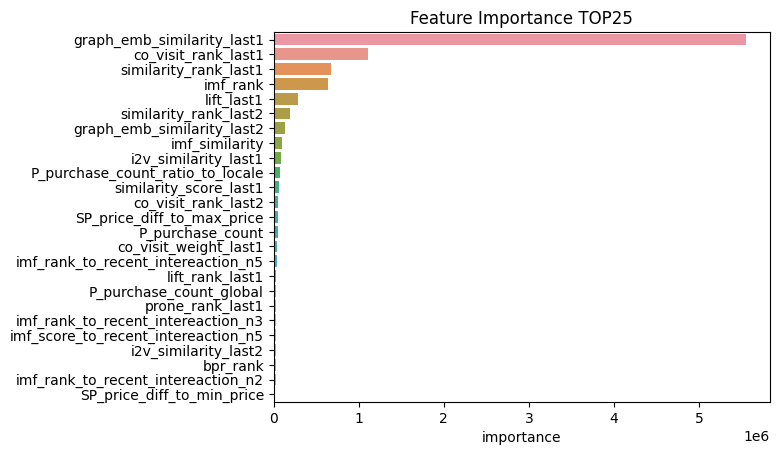

In [15]:
%%time
# train lgbm model
feat_imp = train_lgb_model(train)

# visualize feature importances
fi_df = pd.DataFrame(index=USE_FEATURES)
fi_df["importance"] = feat_imp / K_FOLDS
fi_df = fi_df.sort_values(by="importance", ascending=False).head(25)
sns.barplot(x="importance", y=fi_df.index, data=fi_df).set(title="Feature Importance TOP25")

In [16]:
del train; gc.collect()

0